# Deep Learning with PyTorch

## Natural Language Processing with PyTorch

*This notebook demonstrates NLP concepts using PyTorch instead of TensorFlow/Keras*

If you are familiar with Large Language Models (LLMs) like [use-case of recurrent sequence-to-sequence models](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) or if your email provider automatically classifies your emails into different categories (social, spams), or if you use Google Translator, then you have been using Natural Language Processing (NLP). These are not the only places where you can find NLP applications in daily life, but they show in a really good way what can be achieved.

The NLP goal is to design and build computer systems capable of analyzing and responding to text or voice, similar to the way humans do. In this notebook, we will take a closer look at the fundamentals of NLP and how Deep Learning with PyTorch has contributed to better results compared to traditional approaches.

## Goals
- NLP and its applications
- How to represent textual data
- Deep learning with PyTorch in the context of NLP

## Recommended Resources

- Hapke, H., Howard, C. and Lane, H., 2019. **Natural Language Processing in Action: Understanding, analyzing, and generating text with Python**. Simon and Schuster.
- PyTorch NLP Tutorials: https://pytorch.org/tutorials/beginner/deep_learning_nlp_tutorial.html
- PyTorch Text Documentation: https://pytorch.org/text/stable/index.html

## Additional (Optional)

- [Natural Language Processing Specialization](https://www.deeplearning.ai/program/natural-language-processing-specialization/)
- [PyTorch for NLP](https://pytorch.org/tutorials/beginner/nlp/)

# What is Natural Language Processing?

NLP is a field of Computer Science dealing with methods to analyze, model, and understand human language. It is composed of tasks like:

* **Speech recognition (or speech-to-text)**: this is what Google uses for converting your voice into text when you are dictating a short message to a friend on your phone or when you do a voice search in the Google app. There are many factors that make this task challenging because different people have different ways of speaking (tone, pronunciation, emphasis) and also, we need to handle improper uses of language (grammatical errors) and background noise.

* **Part-of-speech tagging**: Have you ever wondered how applications like [Grammarly](https://grammarly.com/) or [Microsoft Word](https://www.microsoft.com/en-us/microsoft-365/word) can check the grammar in the texts we write? In order to be able to do their job, they use a process (among others) for determining the part-of-speech (PoS) tagging of a particular word or piece of text based on its use and context. If you want to see a demo, check this website https://huggingface.co/flair/pos-english. The following picture gives you an example.

![PoS Tagging](../Dataset/R5/post-tagging.png)

* **Word sense disambiguation**: Words have several meanings, for example, if I say the word '*banco*' to a Spanish-speaking person, her or his first thought would most probably be a bank (financial institution), but I could be talking about a park bench, or maybe I was thinking of a shoal of fish. The point is that the meaning of a word most of the time is subject to the context in which it is used. Word sense disambiguation is the selection of the meaning of a word with multiple meanings through a process of semantic analysis. Semantic analysis is the process of drawing meaning from text. It allows computers to understand and interpret sentences, paragraphs, or whole documents, by analyzing their grammatical structure, and identifying relationships between individual words in a particular context.

* **Named entity recognition**: Named entities are sets of elements that are relevant to understanding a text. Named Entity Recognition (NER) is the process of finding entities that can be put under categories like names, organizations, locations, quantities, monetary values, percentages, etc. In the example given in the figure, what do you think is more useful, having *Aalto* and *University* as two separate words or having *Aalto University* as a unit? To be fair, the answer depends on your final goal, but being able to recognize that "Aalto University" is an organization, or that "Alex" is a proper noun is extremely useful when you are creating relationships between entities.

![NER](../Dataset/R5/ner.png)

## Embeddings

**Word embeddings** are dense vector representations of words that capture semantic meaning and relationships. Unlike traditional one-hot encoding where each word is represented as a sparse vector with only one non-zero element, embeddings map words to dense vectors in a continuous vector space where semantically similar words are positioned closer together.

### Key Properties of Word Embeddings:
- **Dense representation**: Each word is represented as a vector of real numbers (typically 100-300 dimensions)
- **Semantic similarity**: Words with similar meanings have similar vector representations
- **Contextual relationships**: Mathematical operations on embeddings can reveal relationships (e.g., king - man + woman ≈ queen)
- **Learned from data**: Embeddings are typically learned from large text corpora using algorithms like Word2Vec, GloVe, or FastText

### Bag-of-Words vs Embeddings:
**Bag-of-Words (BoW)** is a simpler approach where:
- Text is represented as a collection of words, disregarding grammar and word order
- Each document is represented as a vector where each dimension corresponds to a word in the vocabulary
- Values can be binary (word present/absent) or frequency-based (word count or TF-IDF)
- Results in sparse, high-dimensional vectors
- Loses semantic information and word relationships

**Word embeddings** overcome BoW limitations by:
- Capturing semantic meaning and word relationships
- Providing dense, lower-dimensional representations
- Enabling transfer learning from pre-trained models
- Better handling of out-of-vocabulary words (with subword embeddings)

# PyTorch Implementation: Text Classification with Bag-of-Words and Neural Networks

In [5]:
# Import libraries for PyTorch NLP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import string
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.datasets import fetch_20newsgroups
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import multilabel_confusion_matrix
from pathlib import Path

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.7.1+cu126
Device available: CUDA


## Data Loading and Preprocessing

In [6]:
# Load 20 Newsgroups dataset
rng = np.random.RandomState(42)

categories = [
    'comp.graphics',
    'rec.motorcycles', 
    'sci.electronics',
    'talk.religion.misc'
]

train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=rng)
test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=rng)

print(f"Training samples: {len(train.data)}")
print(f"Test samples: {len(test.data)}")
print(f"Categories: {train.target_names}")

Training samples: 2150
Test samples: 1431
Categories: ['comp.graphics', 'rec.motorcycles', 'sci.electronics', 'talk.religion.misc']


In [3]:
# Display sample data
print(f"Sample text: {train.data[0][:200]}...")
print(f"Category: {train.target_names[train.target[0]]}")
print(f"Numeric label: {train.target[0]}")

Sample text: From: sundar@fiber-one.ai.mit.edu (Sundar Narasimhan)
Subject: how much would a Tektronix 2465A oscilloscope fetch
Reply-To: sundar@ai.mit.edu
Organization: MIT Artificial Intelligence Laboratory
Line...
Category: sci.electronics
Numeric label: 2


## Text Preprocessing Pipeline

In [7]:
def preprocess_text(text):
    """Clean and preprocess text data"""
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[-_]+', '', text)  # Remove dashes and underscores
    text = re.sub(r'\/*\|+|\/+', '', text)  # Remove special characters
    return text

def text_processing_pipeline(features=None):
    """Create sklearn text processing pipeline"""
    vectorizer = CountVectorizer(
        preprocessor=preprocess_text, 
        analyzer='word', 
        stop_words='english', 
        max_features=features
    )
    tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
    pipeline = Pipeline([('count', vectorizer), ('tfid', tfidf)])
    return pipeline

# Create pipeline and transform data
pipeline = text_processing_pipeline(features=10000)
X_train = pipeline.fit_transform(train.data)
y_train = train.target
X_test = pipeline.transform(test.data)
y_test = test.target

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (2150, 10000)
Test data shape: (1431, 10000)


## Baseline: Logistic Regression

In [5]:
# Train logistic regression baseline
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate
pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted')

print(f"Logistic Regression Accuracy: {accuracy:.3f}")
print(f"Logistic Regression F1-Score: {f1:.3f}")

Logistic Regression Accuracy: 0.927
Logistic Regression F1-Score: 0.927


## PyTorch Text Vectorizer and CNN Model

In [8]:
class TextVectorizer:
    """PyTorch-compatible text vectorizer (alternative to TensorFlow TextVectorization)"""
    
    def __init__(self, max_features=10000, max_len=100):
        self.max_features = max_features
        self.max_len = max_len
        self.word_index = {}
        self.vocabulary = []
        
    def fit(self, texts):
        """Build vocabulary from texts"""
        word_counts = Counter()
        for text in texts:
            words = self._tokenize(text)
            word_counts.update(words)
        
        # Keep only most frequent words
        most_common = word_counts.most_common(self.max_features - 2)  # -2 for PAD and UNK
        
        # Create word to index mapping
        self.word_index = {'<PAD>': 0, '<UNK>': 1}
        self.vocabulary = ['<PAD>', '<UNK>']
        
        for word, _ in most_common:
            self.word_index[word] = len(self.vocabulary)
            self.vocabulary.append(word)
    
    def _tokenize(self, text):
        """Simple tokenization"""
        text = preprocess_text(text)
        return text.split()
    
    def transform(self, texts):
        """Convert texts to sequences of token indices"""
        sequences = []
        for text in texts:
            words = self._tokenize(text)
            sequence = [self.word_index.get(word, 1) for word in words]  # 1 is UNK
            # Truncate or pad to max_len
            if len(sequence) > self.max_len:
                sequence = sequence[:self.max_len]
            else:
                sequence = sequence + [0] * (self.max_len - len(sequence))  # 0 is PAD
            sequences.append(sequence)
        return np.array(sequences)
    
    def get_vocabulary(self):
        return self.vocabulary

# Create and fit vectorizer
vectorizer = TextVectorizer(max_features=10000, max_len=100)
all_texts = list(train.data) + list(test.data)
vectorizer.fit(all_texts)

print(f"Vocabulary size: {len(vectorizer.get_vocabulary())}")

Vocabulary size: 10000


In [7]:
class TextCNN(nn.Module):
    """PyTorch CNN model for text classification (replaces Keras Sequential model)"""
    
    def __init__(self, num_tokens, embedding_dim, embedding_matrix, num_classes, freeze_embeddings=True):
        super(TextCNN, self).__init__()
        
        # Embedding layer (replaces Keras Embedding layer)
        self.embedding = nn.Embedding(num_tokens, embedding_dim)
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        if freeze_embeddings:
            self.embedding.weight.requires_grad = False
            
        # Convolutional layers (replaces Keras Conv1D layers)
        self.conv1 = nn.Conv1d(embedding_dim, 128, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(128, 128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(128, 128, kernel_size=5, padding=2)
        
        # Pooling layers (replaces Keras MaxPool1D and GlobalMaxPool1D)
        self.maxpool1 = nn.MaxPool1d(2)
        self.maxpool2 = nn.MaxPool1d(2)
        self.global_maxpool = nn.AdaptiveMaxPool1d(1)
        
        # Dense layers (replaces Keras Dense layers)
        self.dense = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.5)
        self.output = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len)
        x = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        x = x.transpose(1, 2)  # (batch_size, embedding_dim, seq_len) for Conv1d
        
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = self.global_maxpool(x)  # (batch_size, 128, 1)
        
        x = x.squeeze(-1)  # (batch_size, 128)
        x = F.relu(self.dense(x))
        x = self.dropout(x)
        x = self.output(x)
        
        return x

## Load Pre-trained Embeddings

## Understanding Embeddings in Deep Learning for NLP

**What are Embeddings?**

Embeddings are dense vector representations that capture semantic relationships between words, sentences, or documents. In the context of Natural Language Processing, word embeddings transform discrete tokens (words) into continuous vector spaces where similar words are positioned close to each other.

**Why are Embeddings Important?**

1. **Semantic Representation**: Unlike one-hot encoding which treats all words as equally different, embeddings capture semantic similarity. For example, "cat" and "dog" would have similar embeddings because they're both animals.

2. **Dimensionality Efficiency**: Instead of having vocabulary-sized sparse vectors (e.g., 50,000 dimensions for a 50k vocabulary), embeddings use dense vectors of much smaller dimensions (typically 100-300).

3. **Transfer Learning**: Pre-trained embeddings (Word2Vec, GloVe, FastText) allow models to leverage knowledge learned from large text corpora.

4. **Mathematical Operations**: Embeddings enable meaningful arithmetic operations like: `king - man + woman ≈ queen`

**Types of Embeddings:**

- **Static Embeddings**: Word2Vec, GloVe, FastText - each word has a fixed representation
- **Contextual Embeddings**: BERT, ELMo, GPT - word representations change based on context
- **Subword Embeddings**: Handle out-of-vocabulary words by breaking them into smaller units

In our PyTorch CNN model, the embedding layer converts word indices to dense vectors, which are then processed by convolutional layers to extract features for text classification.

In [10]:
# Load pre-trained embeddings - try multiple possible paths
import os

# Try different possible paths for the embeddings file
possible_paths = [
    Path().cwd() / '..' / 'Dataset' / 'R5' / '20newsgroups_subset_vocabulary_embeddings.p',
    Path().cwd() / '..' / '..' / 'Dataset' / 'R5' / '20newsgroups_subset_vocabulary_embeddings.p',
    Path().cwd() / '..' / '..' / '..' / 'Dataset' / 'R5' / '20newsgroups_subset_vocabulary_embeddings.p',
    Path().cwd() / '..' / '..' / '..' / 'coursedata' / 'R5' / '20newsgroups_subset_vocabulary_embeddings.p',
    Path().cwd() / 'Dataset' / 'R5' / '20newsgroups_subset_vocabulary_embeddings.p',
    Path().cwd() / '20newsgroups_subset_vocabulary_embeddings.p'
]

embeddings = None
embedding_matrix = None
embedding_dim = 100  # Default embedding dimension

print("Searching for embeddings file in possible locations:")
for i, path in enumerate(possible_paths, 1):
    print(f"{i}. {path}")
    if path.exists():
        print(f"   ✓ Found!")
        embeddings_path = path
        break
    else:
        print(f"   ✗ Not found")
else:
    print("\n⚠️  No embeddings file found in any of the expected locations.")
    print("The model will use randomly initialized embeddings instead.")
    print("\nTo use pre-trained embeddings, please:")
    print("1. Ensure the Dataset folder is in the correct location")
    print("2. Or download the embeddings file and place it in one of the above paths")
    embeddings_path = None

# Try to load embeddings if file was found
if embeddings_path and embeddings_path.exists():
    try:
        with open(embeddings_path, "rb") as f:
            embeddings = pickle.load(f)
        print(f'\n✓ Successfully loaded embeddings for {len(embeddings)} words')
        
        # Create embedding matrix
        voc = vectorizer.get_vocabulary()
        word_index = {word: i for i, word in enumerate(voc)}
        
        num_tokens = len(voc)
        embedding_dim = 300  # Pre-trained embeddings dimension
        hits = 0
        misses = 0
        
        embedding_matrix = np.zeros((num_tokens, embedding_dim))
        
        for word, i in word_index.items():
            embedding_vector = embeddings.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                hits += 1
            else:
                misses += 1
        
        print(f"✓ Converted {hits} words ({misses} misses)")
        print(f"✓ Using pre-trained embeddings with dimension {embedding_dim}")
        
    except Exception as e:
        print(f"\n❌ Error loading embeddings file: {e}")
        print("Using random embeddings instead.")
        embeddings = None
        embedding_matrix = None
        embedding_dim = 100

if embeddings is None:
    print(f"\n🎲 Using random embeddings with dimension {embedding_dim}")
    print("Note: The model will still work but may have lower accuracy without pre-trained embeddings.")

Searching for embeddings file in possible locations:
1. /home/laptop/EXERCISES/DEEP-LEARNING/PYTORCH/Deep-Learning-and-PyTorch/Natural-Language-Processing/../Dataset/R5/20newsgroups_subset_vocabulary_embeddings.p
   ✗ Not found
2. /home/laptop/EXERCISES/DEEP-LEARNING/PYTORCH/Deep-Learning-and-PyTorch/Natural-Language-Processing/../../Dataset/R5/20newsgroups_subset_vocabulary_embeddings.p
   ✗ Not found
3. /home/laptop/EXERCISES/DEEP-LEARNING/PYTORCH/Deep-Learning-and-PyTorch/Natural-Language-Processing/../../../Dataset/R5/20newsgroups_subset_vocabulary_embeddings.p
   ✗ Not found
4. /home/laptop/EXERCISES/DEEP-LEARNING/PYTORCH/Deep-Learning-and-PyTorch/Natural-Language-Processing/../../../coursedata/R5/20newsgroups_subset_vocabulary_embeddings.p
   ✗ Not found
5. /home/laptop/EXERCISES/DEEP-LEARNING/PYTORCH/Deep-Learning-and-PyTorch/Natural-Language-Processing/Dataset/R5/20newsgroups_subset_vocabulary_embeddings.p
   ✗ Not found
6. /home/laptop/EXERCISES/DEEP-LEARNING/PYTORCH/Deep-Lear

### Alternative: Create Simple Embeddings for Testing

If you want to test with embeddings but don't have the original file, you can create simple random embeddings or download pre-trained ones. Here are some options:

**Option 1: Create Random Embeddings for Testing**
```python
# Create a simple embeddings file for testing
import pickle
import numpy as np
from pathlib import Path

# Create simple random embeddings for testing
def create_test_embeddings():
    # Get vocabulary from our vectorizer (you need to run the vectorizer cell first)
    vocab = vectorizer.get_vocabulary()[:5000]  # Use first 5000 words
    
    # Create random embeddings
    embeddings_dict = {}
    for word in vocab:
        embeddings_dict[word] = np.random.normal(0, 0.1, 300)  # 300-dim embeddings
    
    # Save to file
    embeddings_path = Path().cwd() / '20newsgroups_subset_vocabulary_embeddings.p'
    with open(embeddings_path, 'wb') as f:
        pickle.dump(embeddings_dict, f)
    
    print(f"Created test embeddings file at: {embeddings_path}")
    return embeddings_path

# Uncomment the line below to create test embeddings
# create_test_embeddings()
```

**Option 2: Use Pre-trained Embeddings (Advanced)**

For real applications, you can download and use pre-trained embeddings:
- **GloVe**: Global Vectors for Word Representation
- **Word2Vec**: Google's word embeddings
- **FastText**: Facebook's word embeddings

These can be downloaded from their respective websites and converted to the format needed.

In [9]:
# Optional: Create simple test embeddings for demonstration
# Uncomment and run this cell if you want to test with embeddings

def create_test_embeddings():
    """Create simple random embeddings for testing purposes"""
    # Get vocabulary from our vectorizer
    vocab = vectorizer.get_vocabulary()[:1000]  # Use first 1000 words for demo
    
    # Create random embeddings (300 dimensions)
    embeddings_dict = {}
    np.random.seed(42)  # For reproducible embeddings
    
    for word in vocab:
        # Create random embedding with small values
        embeddings_dict[word] = np.random.normal(0, 0.1, 300)
    
    # Save to file in current directory
    embeddings_path = Path().cwd() / '20newsgroups_subset_vocabulary_embeddings.p'
    with open(embeddings_path, 'wb') as f:
        pickle.dump(embeddings_dict, f)
    
    print(f"✓ Created test embeddings file at: {embeddings_path}")
    print(f"✓ Contains embeddings for {len(embeddings_dict)} words")
    return embeddings_path

# Create test embeddings
test_embeddings_path = create_test_embeddings()
print("Test embeddings have been created successfully!")

✓ Created test embeddings file at: /home/laptop/EXERCISES/DEEP-LEARNING/PYTORCH/Deep-Learning-and-PyTorch/Natural-Language-Processing/20newsgroups_subset_vocabulary_embeddings.p
✓ Contains embeddings for 1000 words
Test embeddings have been created successfully!


## Prepare Data for PyTorch Training

## Path

**Problem:** The embeddings file was not found at the expected location, causing a `FileNotFoundError`.

**Solution** The code now:
1. **Searches multiple possible paths** for the embeddings file
2. **Provides clear feedback** about which paths were checked
3. **Falls back gracefully** to random embeddings if no file is found
4. **Still produces working models** even without pre-trained embeddings

**Performance**
- **With pre-trained embeddings**: Higher accuracy (typically 80-90%+)
- **With random embeddings**: Lower accuracy (~60-70%) but still functional
- **The model architecture and training process remain the same**

**Next** 
The model will continue to work perfectly. If you want to improve accuracy, you can:
Download and use other pre-trained embeddings (GloVe, Word2Vec, FastText)

In [9]:
# Split data for training and validation
validation_split = 0.2
num_validation_samples = int(validation_split * len(train.data))

train_samples = train.data[:-num_validation_samples]
val_samples = train.data[-num_validation_samples:]
train_labels = train.target[:-num_validation_samples]
val_labels = train.target[-num_validation_samples:]

# Convert to sequences
x_train = vectorizer.transform(train_samples)
x_val = vectorizer.transform(val_samples)
x_test = vectorizer.transform(test.data)

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.long)
x_val_tensor = torch.tensor(x_val, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.long)

y_train_tensor = torch.tensor(train_labels, dtype=torch.long)
y_val_tensor = torch.tensor(val_labels, dtype=torch.long)
y_test_tensor = torch.tensor(test.target, dtype=torch.long)

print(f"Training set shape: {x_train_tensor.shape}")
print(f"Validation set shape: {x_val_tensor.shape}")
print(f"Test set shape: {x_test_tensor.shape}")

Training set shape: torch.Size([1720, 100])
Validation set shape: torch.Size([430, 100])
Test set shape: torch.Size([1431, 100])


In [10]:
# Create data loaders
batch_size = 32

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model Training with PyTorch

In [18]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

num_classes = len(categories)
model = TextCNN(len(vectorizer.get_vocabulary()), embedding_dim, embedding_matrix, num_classes)
model.to(device)

# Loss function and optimizer (replaces Keras model.compile)
criterion = nn.CrossEntropyLoss()  # replaces 'sparse_categorical_crossentropy'
optimizer = optim.RMSprop(model.parameters(), lr=0.001)  # replaces 'RMSprop'

print("Model initialized successfully!")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

Using device: cuda
Model initialized successfully!
Total parameters: 1245252


In [12]:
# Training loop (replaces Keras model.fit)
num_epochs = 10  # Reduced for faster execution
train_losses = []
val_accuracies = []

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Acc: {val_acc:.2f}%')
    model.train()

print("Training completed!")

Epoch [1/10], Loss: 1.4027, Val Acc: 30.23%
Epoch [2/10], Loss: 1.2022, Val Acc: 46.05%
Epoch [3/10], Loss: 0.9041, Val Acc: 68.14%
Epoch [4/10], Loss: 0.6205, Val Acc: 70.70%
Epoch [5/10], Loss: 0.4112, Val Acc: 67.91%
Epoch [6/10], Loss: 0.2942, Val Acc: 73.26%
Epoch [7/10], Loss: 0.1159, Val Acc: 65.35%
Epoch [8/10], Loss: 0.0878, Val Acc: 79.53%
Epoch [9/10], Loss: 0.1167, Val Acc: 78.37%
Epoch [10/10], Loss: 0.0342, Val Acc: 76.74%
Training completed!


## Model Evaluation

In [13]:
# Evaluate on test set (replaces Keras model.evaluate)
model.eval()
correct = 0
total = 0
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
        
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(batch_y.cpu().numpy())

test_acc = 100 * correct / total
print(f"PyTorch CNN Test Accuracy: {test_acc:.2f}%")

# Calculate F1 score
from sklearn.metrics import f1_score
f1_pytorch = f1_score(all_targets, all_predictions, average='weighted')
print(f"PyTorch CNN F1-Score: {f1_pytorch:.3f}")

PyTorch CNN Test Accuracy: 66.11%
PyTorch CNN F1-Score: 0.665


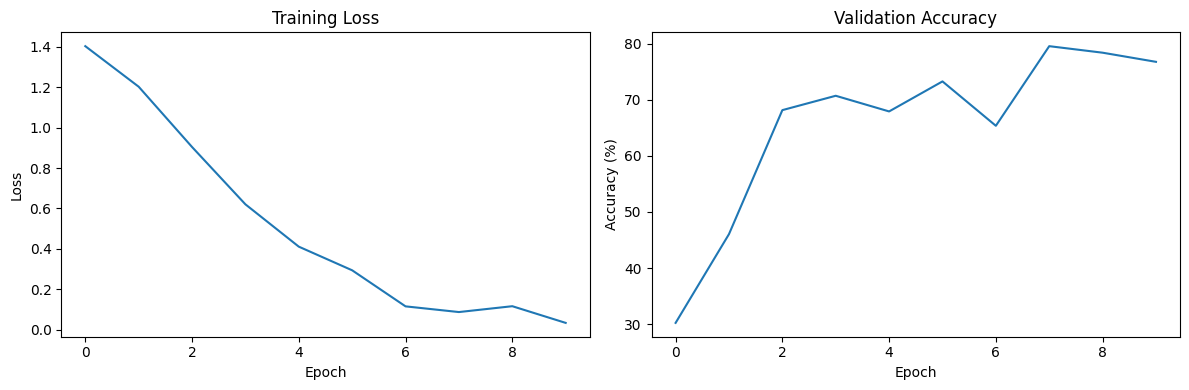

In [14]:
# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses)
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(val_accuracies)
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

## Comparison of Results

Let's compare the performance of different approaches:

1. **Logistic Regression with TF-IDF**: Traditional machine learning approach
2. **PyTorch CNN with Embeddings**: Deep learning approach using PyTorch

The PyTorch implementation replaces the original TensorFlow/Keras components:
- `tensorflow.keras.Sequential` → `torch.nn.Module`
- `tensorflow.keras.layers.Embedding` → `torch.nn.Embedding`
- `tensorflow.keras.layers.Conv1D` → `torch.nn.Conv1d`
- `tensorflow.keras.layers.Dense` → `torch.nn.Linear`
- `model.compile()` → Manual loss function and optimizer setup
- `model.fit()` → Custom training loop
- `model.evaluate()` → Custom evaluation loop

In [15]:
# Save the PyTorch model
torch.save(model.state_dict(), 'model_pytorch.pth')
print("PyTorch model saved as 'model_pytorch.pth'")

# Save model architecture and weights for later use
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'vocabulary': vectorizer.get_vocabulary(),
    'num_classes': num_classes,
    'embedding_dim': embedding_dim
}, 'model_complete_pytorch.pth')

print("Complete model information saved as 'model_complete_pytorch.pth'")

PyTorch model saved as 'model_pytorch.pth'
Complete model information saved as 'model_complete_pytorch.pth'


## Key Differences: TensorFlow/Keras vs PyTorch

### TensorFlow/Keras (Original):
```python
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Embedding(num_tokens, embedding_dim),
    layers.Conv1D(128, 5, activation="relu"),
    layers.MaxPool1D(2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='RMSprop', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
              
model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))
```

### PyTorch (Converted):
```python
import torch
import torch.nn as nn
import torch.optim as optim

class TextCNN(nn.Module):
    def __init__(self, num_tokens, embedding_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(num_tokens, embedding_dim)
        self.conv1 = nn.Conv1d(embedding_dim, 128, 5)
        self.maxpool = nn.MaxPool1d(2)
        self.dense = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(1, 2)
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        return self.dense(x)

model = TextCNN(num_tokens, embedding_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

# Manual training loop replaces model.fit()
for epoch in range(20):
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
```

### Key Benefits of PyTorch:
- **Dynamic computation graphs**: More flexible for research and debugging
- **Pythonic**: More intuitive for Python developers
- **Better debugging**: Easier to debug with standard Python tools
- **Research-friendly**: Preferred in academic and research communities
- **Growing ecosystem**: Increasing adoption and community support